<a href="https://colab.research.google.com/github/matmnds/stud_python/blob/main/taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['grid.color'] = '#cccccc'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 11

# Импорт и обработка данных

In [ ]:
DATA_PATH = 'taxi_data.xlsx'
def load_and_preprocess(path: str) -> pd.DataFrame:
    try:
        df = pd.read_excel(path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Файл не найден по пути: {path}")
    except Exception as e:
        raise RuntimeError(f"Не удалось загрузить файл: {e}")

    expected_cols = {
        'id_order', 'order_time', 'offer_time', 'assign_time',
        'arrive_time', 'trip_time', 'city'
    }
    missing = expected_cols - set(df.columns)
    if missing:
        raise ValueError(f"Отсутствуют обязательные колонки: {missing}")

    date_cols = ['order_time', 'offer_time', 'assign_time', 'arrive_time', 'trip_time']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format="%d.%m.%y %H:%M", errors='coerce')

    # Создаём вспомогательные столбцы
    df['day_order'] = df['order_time'].dt.day
    df['hour_order'] = df['order_time'].dt.floor('h')

    return df

df = load_and_preprocess(DATA_PATH)
df.head()

,id_order,order_time,offer_time,assign_time,arrive_time,trip_time,flag_trip,city,lat,long,day_order,hour_order
0,10905526,2025-05-21 19:11:48,2025-05-21 19:18:24,2025-05-21 19:19:20,2025-05-21 19:30:46,2025-05-21 20:33:04,1,Санкт-Петербург,59.952090,30.312834,21,2025-05-21 19:00:00
1,10903281,2025-05-19 06:54:33,2025-05-19 06:56:37,2025-05-19 06:56:54,NaT,NaT,0,Санкт-Петербург,59.863560,30.382860,19,2025-05-19 06:00:00
2,10903437,2025-05-19 10:30:38,2025-05-19 10:33:15,NaT,NaT,NaT,0,Санкт-Петербург,59.997749,30.375674,19,2025-05-19 10:00:00
3,10908003,2025-05-24 17:13:59,2025-05-24 17:18:54,2025-05-24 17:19:11,2025-05-24 17:22:08,2025-05-24 19:13:59,1,Москва,55.711214,37.520350,24,2025-05-24 17:00:00
4,10903649,2025-05-19 15:47:20,2025-05-22 19:16:44,2025-05-22 19:20:01,2025-05-22 19:27:01,2025-05-22 21:04:04,1,Санкт-Петербург,59.981595,30.419244,19,2025-05-19 15:00:00


In [ ]:
def flag_delayed_orders(df: pd.DataFrame,
                        time_col_start='order_time',
                        time_col_end='trip_time',
                        method='iqr',
                        threshold_multiplier=1.5) -> pd.Series:
    # Вычисляем разницу в минутах между order_time и trip_time
    delta = (df[time_col_end] - df[time_col_start]).dt.total_seconds() / 60
    delta = delta.dropna()

    if method == 'iqr':
        Q1 = np.percentile(delta, 25)
        Q3 = np.percentile(delta, 75)
        IQR = Q3 - Q1
        lower = Q1 - threshold_multiplier * IQR
        upper = Q3 + threshold_multiplier * IQR
        # счётчик выбросов выше верхней границы
        flags = ( (df[time_col_end] - df[time_col_start]).dt.total_seconds() / 60 ) > upper
    elif method == 'percentile':
        pct = np.percentile(delta, threshold_multiplier)
        flags = ((df[time_col_end] - df[time_col_start]).dt.total_seconds() / 60) > pct
    else:
        raise ValueError("method должен быть либо 'iqr', либо 'percentile'")

    return flags.fillna(False)

# Добавляем столбец 'is_delayed' в DataFrame
df['is_delayed'] = flag_delayed_orders(df, method='iqr', threshold_multiplier=1.5)
# Проверим долю «отложенных»:
print("Доля отложенных заказов: {:.2%}".format(df['is_delayed'].mean()))

Доля отложенных заказов: 4.69%


# Основные метрики

In [ ]:
def compute_daily_metrics(df: pd.DataFrame,
                          group_cols=['day_order'],
                          include_delayed=False) -> pd.DataFrame:
    groupers = list(group_cols)
    if include_delayed and 'is_delayed' not in groupers:
        groupers.append('is_delayed')

    agg_dict = {
        'id_order': 'count',
        'offer_time': 'count',
        'assign_time': 'count',
        'arrive_time': 'count',
        'trip_time': 'count'
    }
    df_grp = df.groupby(groupers, as_index=False).agg(
        cnt_order=('id_order', 'count'),
        cnt_offer=('offer_time', 'count'),
        cnt_assign=('assign_time', 'count'),
        cnt_arrive=('arrive_time', 'count'),
        cnt_trip=('trip_time', 'count')
    )
    # Вычисляем конверсии
    df_grp['order2offer'] = df_grp['cnt_offer'] / df_grp['cnt_order']
    df_grp['offer2assign'] = df_grp['cnt_assign'] / df_grp['cnt_offer'].replace(0, np.nan)
    df_grp['assign2arrive'] = df_grp['cnt_arrive'] / df_grp['cnt_assign'].replace(0, np.nan)
    df_grp['arrive2trip'] = df_grp['cnt_trip'] / df_grp['cnt_arrive'].replace(0, np.nan)
    df_grp['order2trip'] = df_grp['cnt_trip'] / df_grp['cnt_order']
    df_grp.fillna(0, inplace=True)
    return df_grp

# 1) По дням без сегментации по отложенным
daily_metrics = compute_daily_metrics(df, group_cols=['day_order'], include_delayed=False)
display(daily_metrics.head())

# 2) По дням и городам с учётом отложенных
daily_city_metrics = compute_daily_metrics(df, group_cols=['day_order','city'], include_delayed=True)
display(daily_city_metrics.head())

,day_order,cnt_order,cnt_offer,cnt_assign,cnt_arrive,cnt_trip,order2offer,offer2assign,assign2arrive,arrive2trip,order2trip
0,19,902,732,567,380,348,0.811530,0.774590,0.670194,0.915789,0.385809
1,20,907,750,540,370,325,0.826902,0.720000,0.685185,0.878378,0.358324
2,21,872,735,545,407,368,0.842890,0.741497,0.746789,0.904177,0.422018
3,22,810,686,551,414,375,0.846914,0.803207,0.751361,0.905797,0.462963
4,23,851,730,606,355,326,0.857814,0.830137,0.585809,0.918310,0.383079


,day_order,city,is_delayed,cnt_order,cnt_offer,cnt_assign,cnt_arrive,cnt_trip,order2offer,offer2assign,assign2arrive,arrive2trip,order2trip
0,19,Казань,False,136,79,66,46,44,0.580882,0.835443,0.69697,0.956522,0.323529
1,19,Казань,True,6,6,6,6,6,1.000000,1.000000,1.00000,1.000000,1.000000
2,19,Краснодар,False,62,47,40,26,17,0.758065,0.851064,0.65000,0.653846,0.274194
3,19,Краснодар,True,4,4,4,4,4,1.000000,1.000000,1.00000,1.000000,1.000000
4,19,Москва,False,409,344,240,195,177,0.841076,0.697674,0.81250,0.907692,0.432763


In [ ]:
# проверим для всех «отложенных» строк, сколько из них имеют ненулевой offer_time, assign_time и arrive_time
delayed = df[df['is_delayed'] == True]
print("Доля delayed с offer_time:", delayed['offer_time'].notna().mean())
print("Доля delayed с assign_time:", delayed['assign_time'].notna().mean())
print("Доля delayed с arrive_time:", delayed['arrive_time'].notna().mean())

Доля delayed с offer_time: 1.0
Доля delayed с assign_time: 1.0
Доля delayed с arrive_time: 1.0


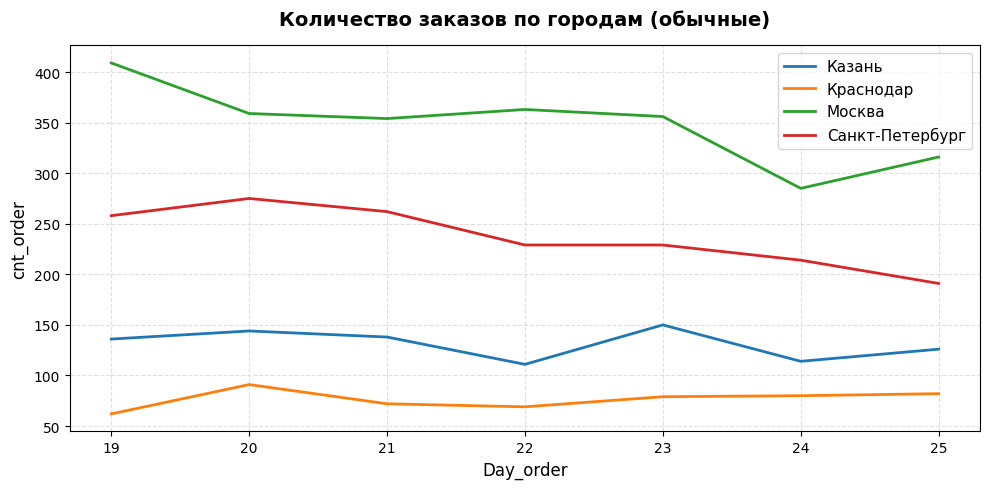

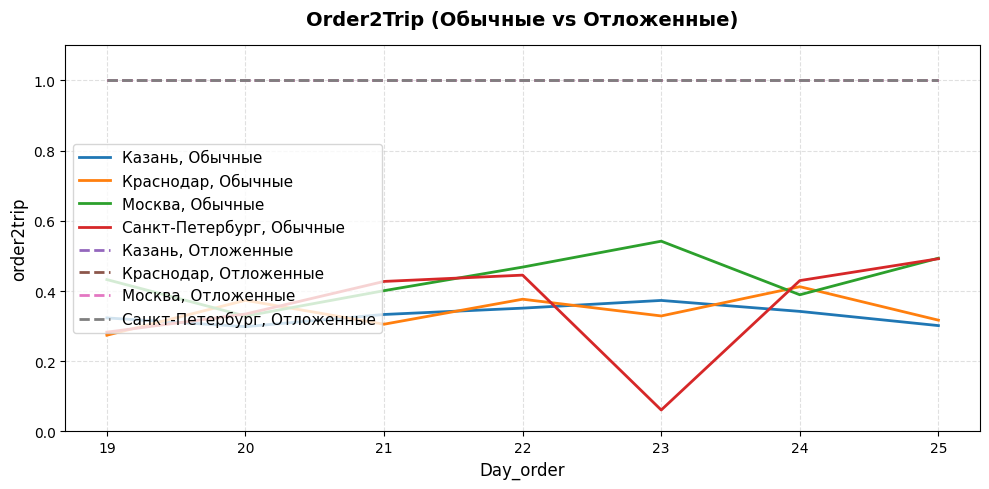

In [ ]:
def plot_time_series(df_metrics: pd.DataFrame,
                     metric: str,
                     x_col: str = 'day_order',
                     hue_col: str = 'city',
                     style_col: str = None,
                     title: str = '',
                     ylim: tuple = None):
    fig, ax = plt.subplots()

    if style_col:
        unique_styles = df_metrics[style_col].unique()
        linestyles = {False: '-', True: '--'}
        labels = {False: 'Обычные', True: 'Отложенные'}
        for style in unique_styles:
            subset = df_metrics[df_metrics[style_col] == style]
            for city in subset[hue_col].unique():
                sub2 = subset[subset[hue_col] == city]
                ax.plot(
                    sub2[x_col],
                    sub2[metric],
                    label=f"{city}, {labels[style]}",
                    linestyle=linestyles.get(style, '-'),
                    linewidth=2
                )
    else:
        for city in df_metrics[hue_col].unique():
            sub = df_metrics[df_metrics[hue_col] == city]
            ax.plot(
                sub[x_col],
                sub[metric],
                label=city,
                linewidth=2
            )

    ax.set_title(title, pad=15)
    ax.set_xlabel(x_col.capitalize())
    ax.set_ylabel(metric)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(True, alpha=0.6)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Количество заказов по городам (без разделения на отложенные)
plot_time_series(
    df_metrics=daily_city_metrics[daily_city_metrics['is_delayed'] == False],
    metric='cnt_order',
    x_col='day_order',
    hue_col='city',
    title='Количество заказов по городам (обычные)'
)

# Конверсия order2trip с разделением на обычные / отложенные
plot_time_series(
    df_metrics=daily_city_metrics,
    metric='order2trip',
    x_col='day_order',
    hue_col='city',
    style_col='is_delayed',
    title='Order2Trip (Обычные vs Отложенные)',
    ylim=(0, 1.1)
)

In [ ]:
def generate_alerts(df_metrics: pd.DataFrame,
                    key_col: str = 'day_order',
                    alert_metric: str = 'cnt_order',
                    sigma: float = 3.0) -> pd.DataFrame:
    df_copy = df_metrics.copy()
    μ = df_copy[alert_metric].mean()
    σ = df_copy[alert_metric].std()

    lower = μ - sigma * σ
    upper = μ + sigma * σ

    df_copy['alert'] = ((df_copy[alert_metric] < lower) | (df_copy[alert_metric] > upper))
    return df_copy

# Генерируем алёрты
alerts_df = generate_alerts(daily_metrics, key_col='day_order', alert_metric='cnt_order', sigma=2.5)

# Проверяем, есть ли аномальные дни
if alerts_df['alert'].any():
    print("Обнаружены аномальные дни по количеству заказов:")
    display(alerts_df[alerts_df['alert']])
else:
    print("Аномальных дней по количеству заказов не обнаружено.")

Аномальных дней по количеству заказов не обнаружено.


# Звенья конверсии

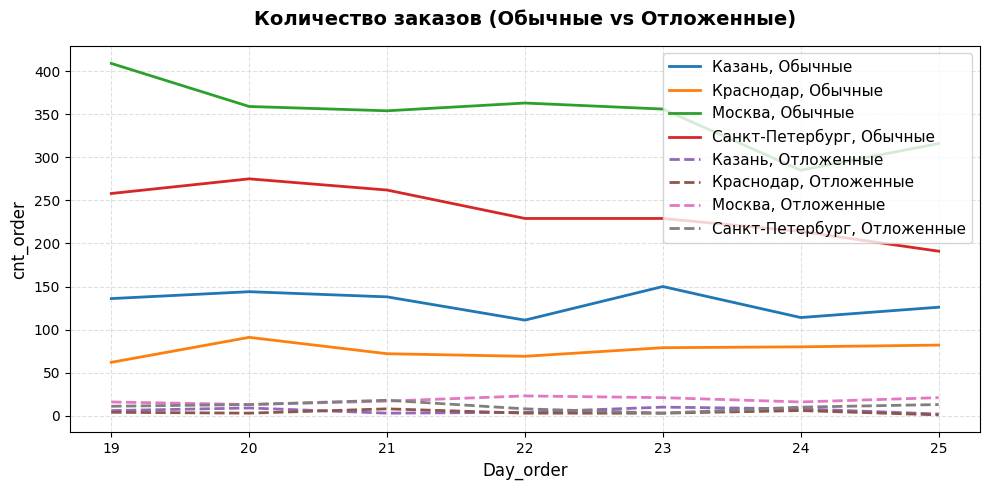

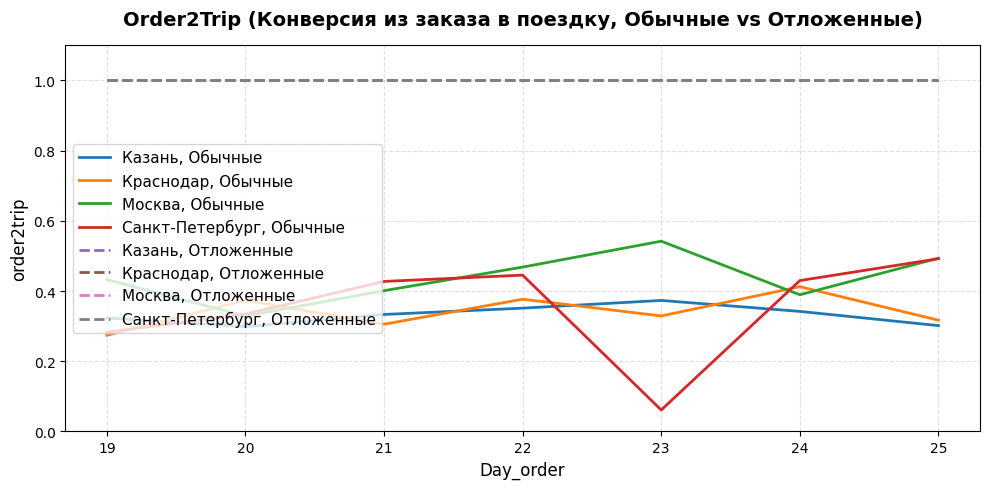

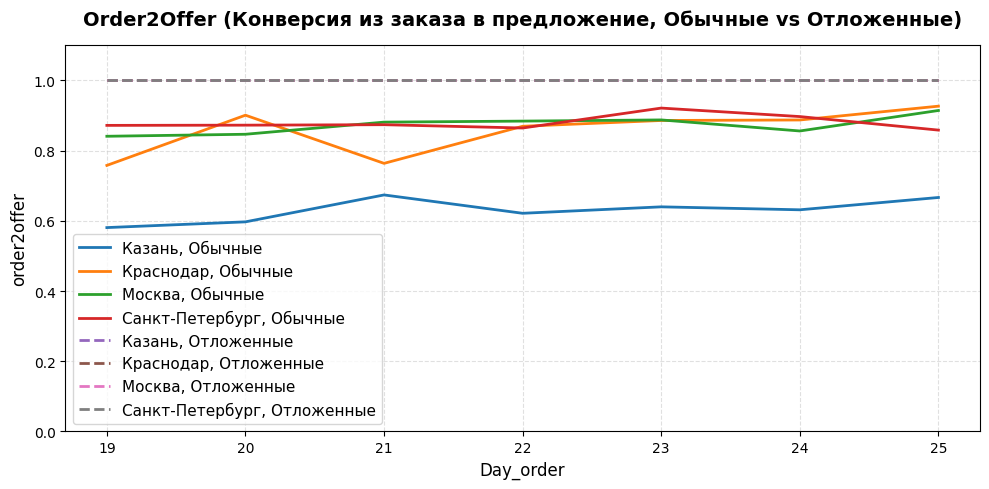

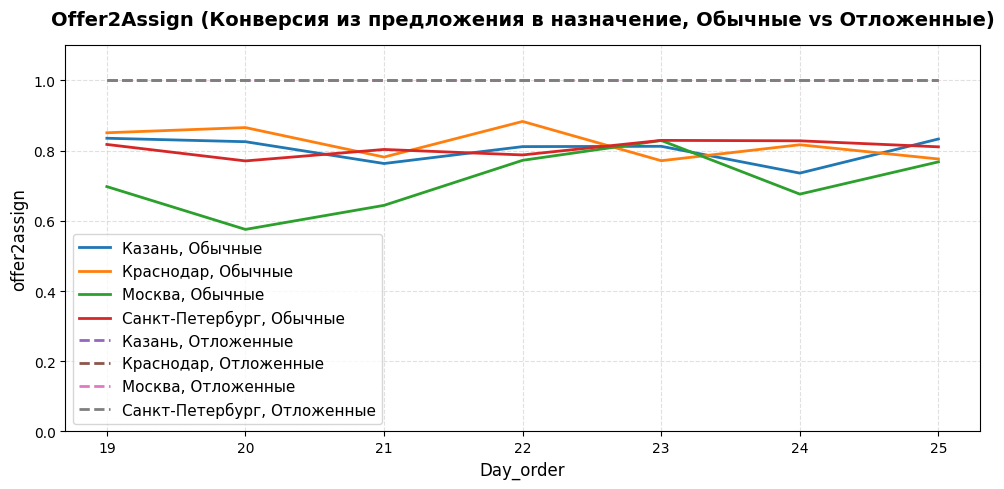

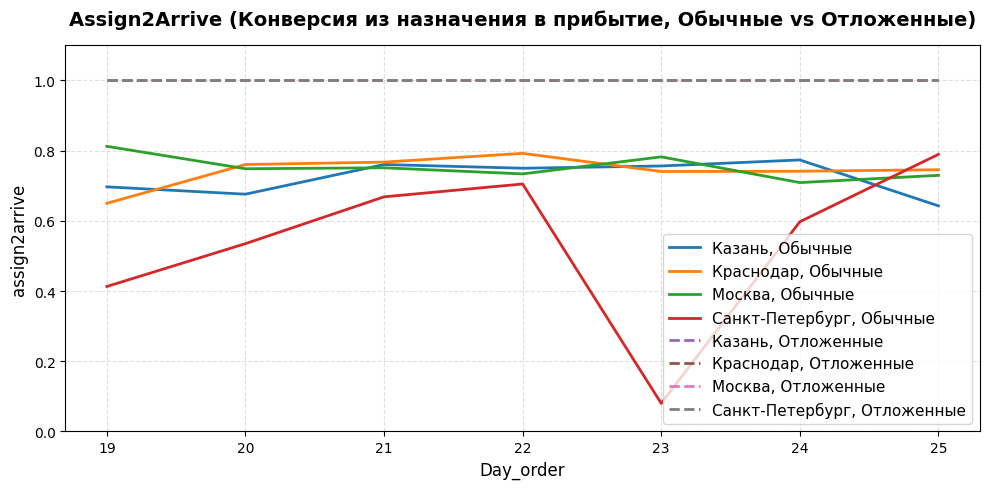

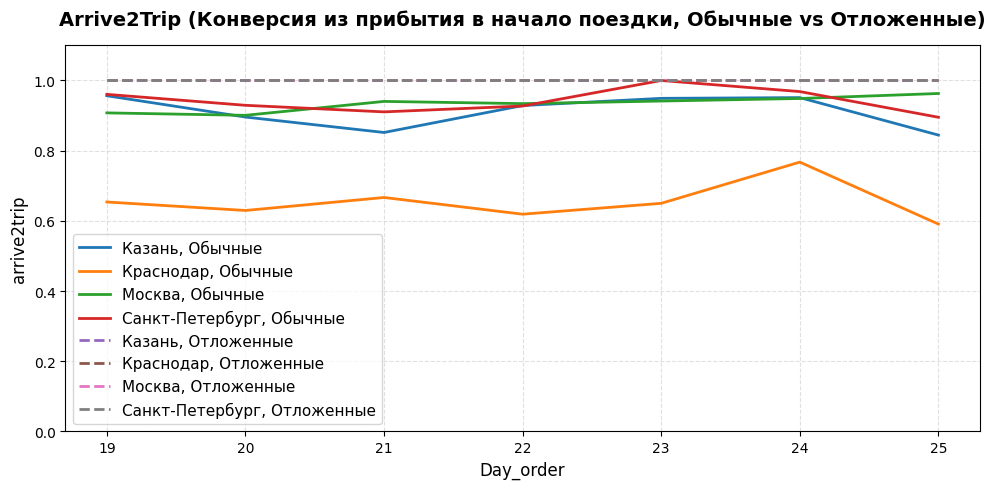

In [ ]:
# Количество заказов (cnt_order) по городам (обычные + отложенные)
plot_time_series(
    df_metrics=daily_city_metrics,
    metric='cnt_order',
    x_col='day_order',
    hue_col='city',
    style_col='is_delayed',
    title='Количество заказов (Обычные vs Отложенные)'
)

# Базовая конверсия order2trip
plot_time_series(
    df_metrics=daily_city_metrics,
    metric='order2trip',
    x_col='day_order',
    hue_col='city',
    style_col='is_delayed',
    title='Order2Trip (Конверсия из заказа в поездку, Обычные vs Отложенные)',
    ylim=(0, 1.1)
)

# Конверсия order2offer (из заказа в предложение)
plot_time_series(
    df_metrics=daily_city_metrics,
    metric='order2offer',
    x_col='day_order',
    hue_col='city',
    style_col='is_delayed',
    title='Order2Offer (Конверсия из заказа в предложение, Обычные vs Отложенные)',
    ylim=(0, 1.1)
)

# Конверсия offer2assign (из предложения в назначение)
plot_time_series(
    df_metrics=daily_city_metrics,
    metric='offer2assign',
    x_col='day_order',
    hue_col='city',
    style_col='is_delayed',
    title='Offer2Assign (Конверсия из предложения в назначение, Обычные vs Отложенные)',
    ylim=(0, 1.1)
)

# Конверсия assign2arrive (из назначения в прибытие)
plot_time_series(
    df_metrics=daily_city_metrics,
    metric='assign2arrive',
    x_col='day_order',
    hue_col='city',
    style_col='is_delayed',
    title='Assign2Arrive (Конверсия из назначения в прибытие, Обычные vs Отложенные)',
    ylim=(0, 1.1)
)

# Конверсия arrive2trip (из прибытия в завершение поездки)
plot_time_series(
    df_metrics=daily_city_metrics,
    metric='arrive2trip',
    x_col='day_order',
    hue_col='city',
    style_col='is_delayed',
    title='Arrive2Trip (Конверсия из прибытия в начало поездки, Обычные vs Отложенные)',
    ylim=(0, 1.1)
)